In [3]:
import io
#npx degit jghawaly/CSC7809_FoundationModels/Project2/data/raw raw/                             
import os, glob
from typing import Tuple
import numpy as np
import torch
import numpy as np
from functools import reduce
import sentencepiece as spm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW, lr_scheduler
from torcheval.metrics.metric import Metric
from torcheval.metrics.text import Perplexity, BLEUScore
import json
from tqdm import tqdm
from datetime import datetime
from word_prediction import TokenizedDataset, read_jsonl, add_special_token, train_seq_model, training_kit
from models import LSTM, RNNModel


In [39]:
def read_jsonl(pat):
    with open(pat, 'r') as f:
        data = [json.loads(line) for line in f]
    return data
def add_special_token(prompt, completion):
    # If the beginning of the prompt is upper case, then we assume it is the start of a sequence
    if prompt[0].isupper():
        prompt = '<bos>' + prompt
    # If the end of the completion is a terminating punctuation, then we assume it is the end of a sequence
    if completion.endswith('.') or completion.endswith('?') or completion.endswith('!'):
        completion += '<eos>'
    return  prompt, completion
def collation(batch):
    input_batch, target_batch = zip(*batch)
    input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value=3)
    target_batch = torch.nn.utils.rnn.pad_sequence(target_batch, batch_first=True, padding_value=3)
    return input_batch, target_batch




device = 'cpu'
#rnnmodel = RNNModel(embed_dim=embed_dim,
#                    hidden_size=hidden_size,
#                    output_size=output_size,
#                    batch_size=batch_size,
#                    n_layers=4,
#                    device=device,
#                    tokenizer=sp,
#                    name="rnn")

#metrics = {
#    'perp': Perplexity(ignore_index=3),
#    'bleu': BLEUScore(n_gram=2)
#}


In [40]:
tokenizer_location = "bptokenizer.model"
training_data = read_jsonl('./data/train.jsonl')
testing_data = read_jsonl('./data/test.jsonl')
sp = spm.SentencePieceProcessor(tokenizer_location)


In [41]:
# Some arbitrary parameters for the example
hidden_size = 24  # Number of hidden units
output_size = sp.vocab_size() # Output dimension
seq_len = 48  # Length of the input sequence
batch_size = 256  # Number of sequences in a batch
embed_dim = 128

In [42]:

 
training_loader = DataLoader(
    TokenizedDataset(training_data, sp, seq_len),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collation
) 
valset, trainset = torch.utils.data.random_split(TokenizedDataset(testing_data, sp, seq_len), [.8, .2])
validation_loader = DataLoader(
    valset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=collation
)



In [43]:
lstmmodel = LSTM(embed_dim=embed_dim,
                 hidden_size=hidden_size,
                 output_size=output_size,
                 batch_size=batch_size,
                 n_layers=4,
                 device=device,
                 tokenizer=sp,
                 name="lstm")
trainkit = training_kit(params=lstmmodel.parameters(),
                        lr=0.001,
                        weight_decay=0.01,
                        dataloader=training_loader,
                        valloader=validation_loader,
                        batch_size=batch_size)

In [44]:
lstmtraining_loss, lstmvalidation_loss = train_seq_model(lstmmodel, train_kit=trainkit)

EPOCH 0 Loss: 9.222513198852539
EPOCH 0 Loss: 9.219687461853027
EPOCH 0 Loss: 9.215144157409668
EPOCH 0 Loss: 9.212550163269043
EPOCH 0 Loss: 9.20722484588623
EPOCH 0 Loss: 9.203514099121094
EPOCH 0 Loss: 9.200922012329102
EPOCH 0 Loss: 9.196148872375488
EPOCH 0 Loss: 9.190802574157715
EPOCH 0 Loss: 9.188765525817871
EPOCH 0 Loss: 9.183353424072266
EPOCH 0 Loss: 9.178791999816895
EPOCH 0 Loss: 9.17341423034668
EPOCH 0 Loss: 9.169004440307617
EPOCH 0 Loss: 9.162275314331055
EPOCH 0 Loss: 9.155675888061523
EPOCH 0 Loss: 9.15125846862793
EPOCH 0 Loss: 9.139986038208008
EPOCH 0 Loss: 9.135212898254395
EPOCH 0 Loss: 9.125052452087402
EPOCH 0 Loss: 9.112476348876953
EPOCH 0 Loss: 9.1029052734375
EPOCH 0 Loss: 9.090648651123047
EPOCH 0 Loss: 9.072601318359375
EPOCH 0 Loss: 9.056097984313965
EPOCH 0 Loss: 9.039756774902344
EPOCH 0 Loss: 9.011175155639648
EPOCH 0 Loss: 8.989375114440918
EPOCH 0 Loss: 8.955851554870605
EPOCH 0 Loss: 8.9258394241333
EPOCH 0 Loss: 8.891658782958984
EPOCH 0 Loss: 8

In [45]:
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

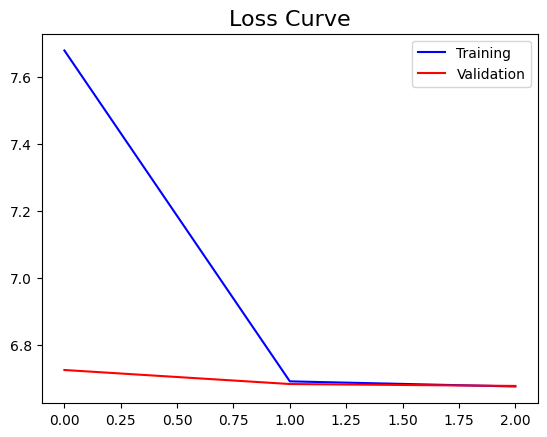

In [46]:
plt.plot(lstmtraining_loss, color='b', label='Training')
plt.plot(lstmvalidation_loss, color='r', label="Validation")
plt.title("Loss Curve", size=16)
plt.legend()

In [47]:
#lstmmodel.load_state_dict(torch.load('./model_20250325_233555.torch'))
lstmmodel.eval()
print(lstmmodel.prompt('The wizard of waverly place'))

C:\Users\jngu195\foundation_ai_p2\models.py:125: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = logits.view(-1)


RuntimeError: a Tensor with 8 elements cannot be converted to Scalar